<h1 align='center'><b>Фреймворк PyTorch для разработки искусственных нейронных сетей<b></h1>

<h2 align='center'>Урок 5. Сегментация изображений</h2>

<h3 align='left'>Практическое задание:</h3>  

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)







## 1. Подготовка датасета

### 1. Загрузка библиотек

In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
# import os
from pathlib import Path
import cv2
import segmentation_models_pytorch as smp

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import models
from segmentation_models_pytorch import utils

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

### 2. Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip -qq '/content/drive/MyDrive/Colab_Notebooks/24_PyTorch/work_5/data/archive.zip'

In [ ]:
DATA_ROOT = '/content/set-lipstick-original/'

In [ ]:
df = pd.read_csv(DATA_ROOT + 'list.csv')
df.head(3)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png


In [ ]:
df.shape

(28594, 9)

In [ ]:
df.isna().sum()

filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
mask        0
dtype: int64

Пропуски отсутствуют

In [ ]:
df = df[['filename', 'mask']]
df.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


Проверим, все ли изображения имеют маски

In [ ]:
list_images = sorted([i for i in Path(DATA_ROOT + '720p').iterdir()])
list_masks = sorted([i for i in Path(DATA_ROOT + 'mask').iterdir()])
len(list_images), len(list_masks)

(28594, 28540)

Удалим изображения, для которых нет масок

In [ ]:
df = df.loc[df['mask'].isin([i.name for i in list_masks])]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


#### Пример данных

(720, 1280, 3)


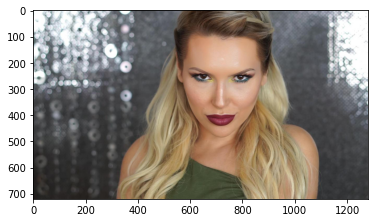

In [ ]:
img = plt.imread(DATA_ROOT + '720p/image00000001.jpg')
print(img.shape)
plt.imshow(img);

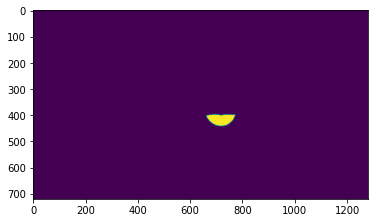

In [ ]:
mask = plt.imread(DATA_ROOT + 'mask/mask00000001.png')
plt.imshow(mask[..., 1]);

In [ ]:
img.shape, mask.shape

((720, 1280, 3), (720, 1280, 3))

### 3.  Создаем Dataset для загрузки данных

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значений
        img = cv2.cvtColor(cv2.imread(DATA_ROOT + '720p/' + self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
           # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # считаем сегментированную картинку
        mask = cv2.cvtColor(cv2.imread(DATA_ROOT + 'mask/' + self.label_arr[index]), cv2.COLOR_BGR2RGB)
        cls_mask = mask[:, :, 1]
        cls_mask = np.where(mask > 10, 1, 0)[:, :, 1]
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks = [cls_mask]
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)    
        
            
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

#### Пример изображения

<ipython-input-119-d34d3f9f78a4>:41: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


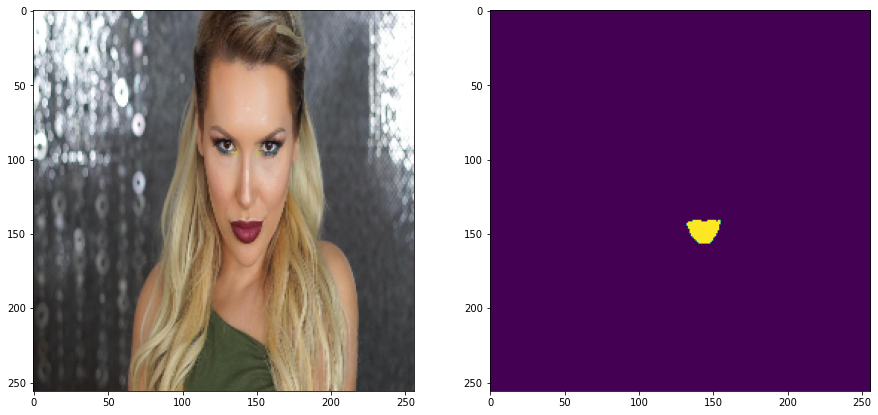

In [ ]:
dataset = MyDataset(df)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[:, :, 0])
plt.show()

### 4. Dataloader

Разделим наш датасет на тренировочную и тестовую выборки. И обернем их в наш кастомный класс.

In [ ]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

train_data = MyDataset(X_train)
test_data = MyDataset(X_test)

И теперь уже обернем то, что получилось в известные нам в pytorch даталоадеры:

In [ ]:
train_data_loader = DataLoader(train_data,
                          batch_size=16,
                          shuffle=True,
                          num_workers=2)

test_data_loader = DataLoader(test_data,
                          batch_size=8,
                          shuffle=False,
                          num_workers=2)

## 2. Обучение модели

Получаем устройство, на котором будем обучаться

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
activation = torch.nn.Softmax(dim=1)

In [ ]:
# создание модели
BACKBONE = 'resnet34' 
segmodel = smp.Unet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet') 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

In [ ]:
# это простой цикл перебора образцов загрузчика данных
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [ ]:
# train model

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
train:   0%|          | 0/1249 [00:00<?, ?it/s]

<ipython-input-119-d34d3f9f78a4>:41: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
<ipython-input-119-d34d3f9f78a4>:41: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


valid:   0%|          | 0/1071 [00:00<?, ?it/s]

<ipython-input-119-d34d3f9f78a4>:41: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
<ipython-input-119-d34d3f9f78a4>:41: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


valid: 100%|██████████| 1071/1071 [10:42<00:00,  1.67it/s, dice_loss - 0.06349, iou_score - 0.8866]
Model saved!


In [ ]:
data_iter = iter(train_data_loader)
# images, labels = data_iter.next()
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

<ipython-input-119-d34d3f9f78a4>:41: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
<ipython-input-119-d34d3f9f78a4>:41: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


Визуализируем сеть. На некоторых изображениях кажется, что сеть сегментировала изображения лучше, чем разметка.

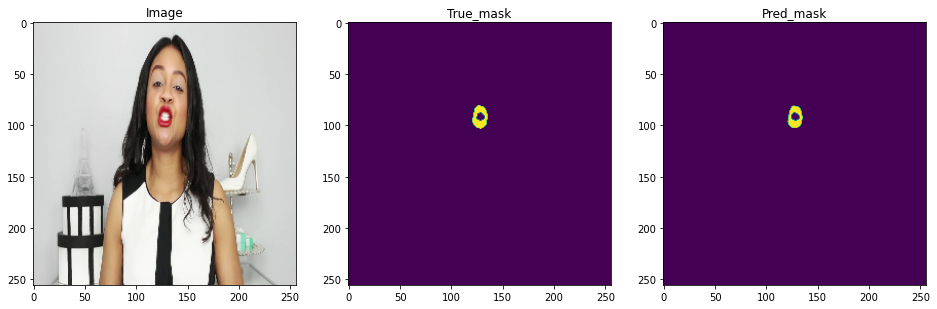

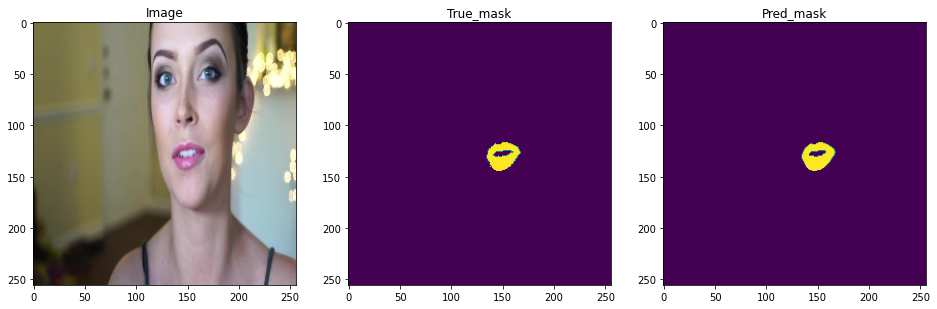

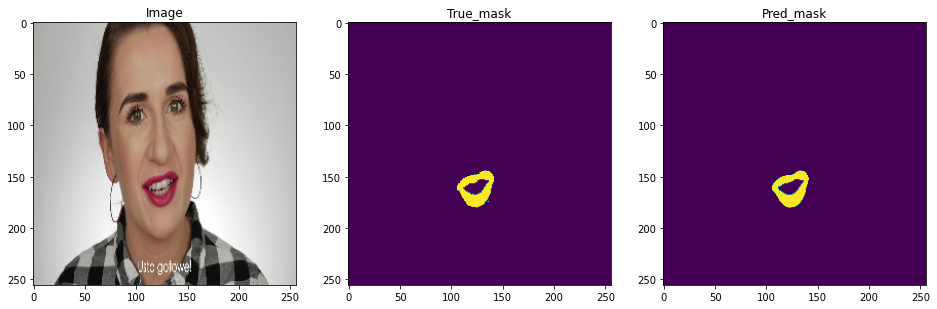

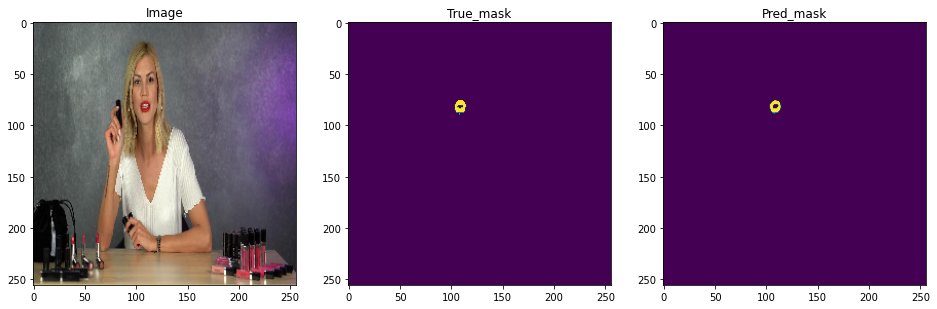

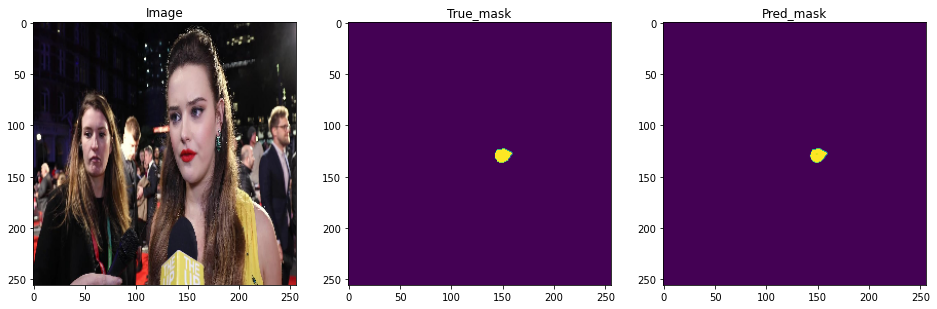

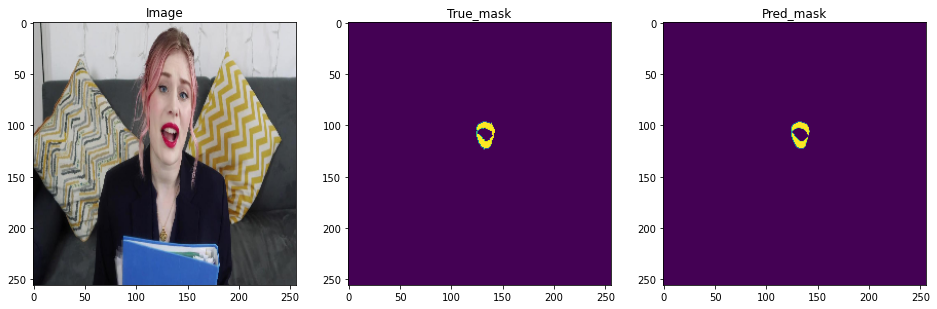

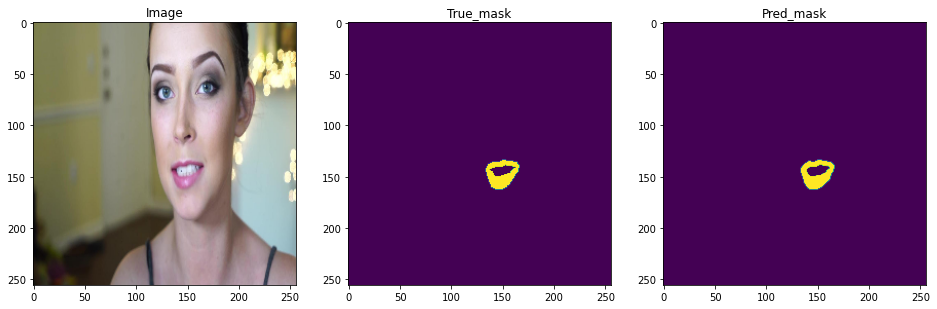

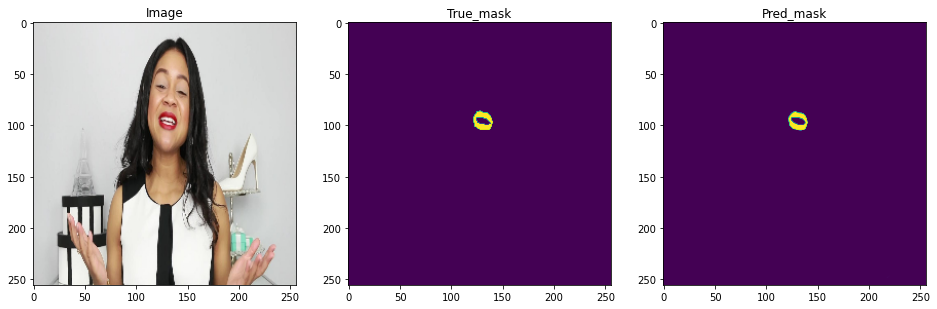

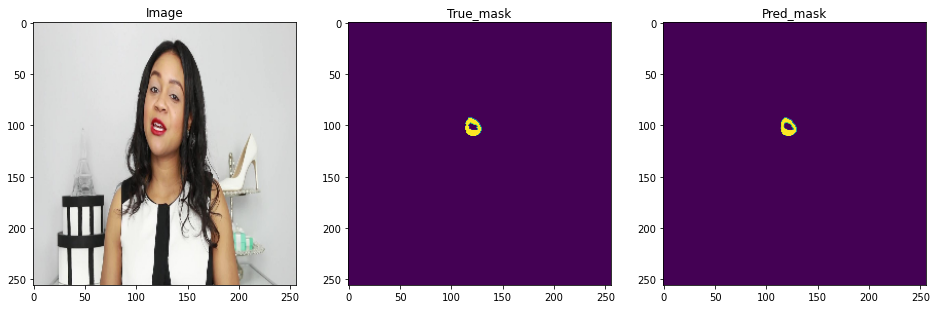

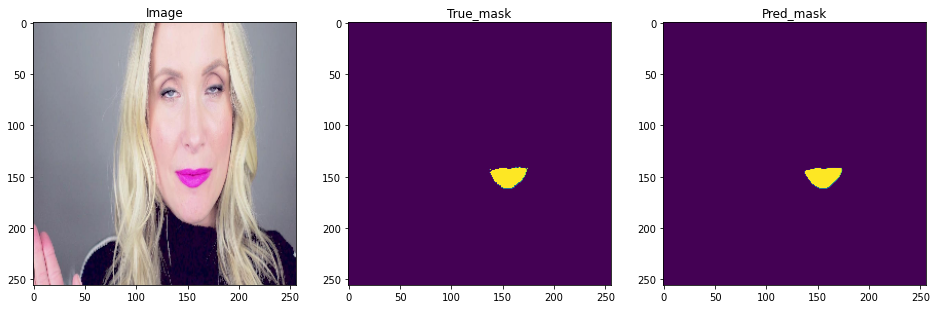

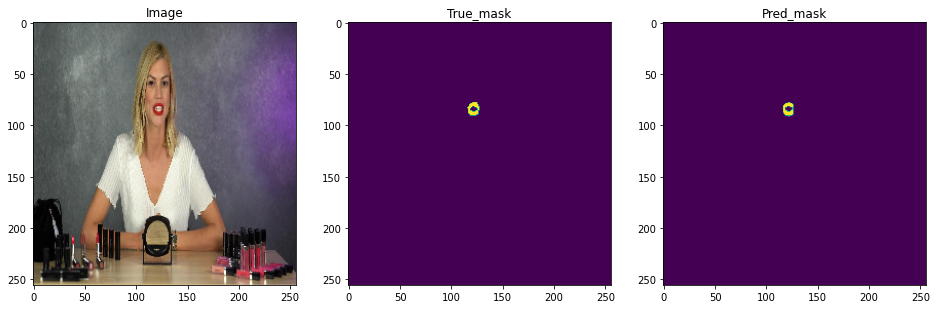

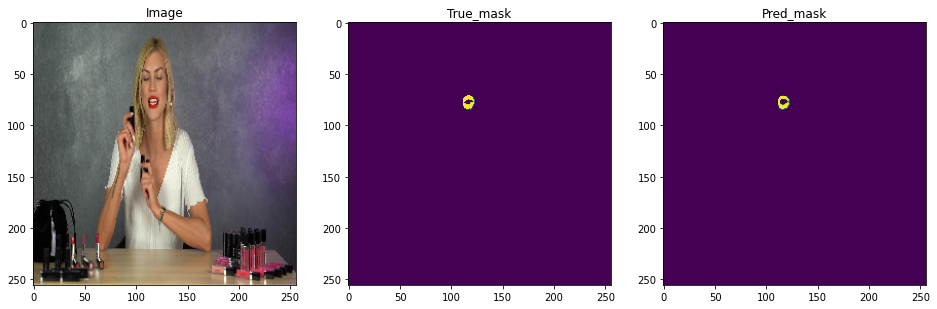

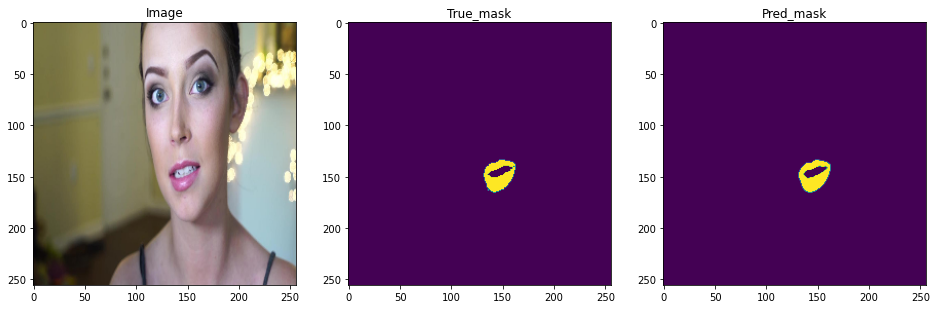

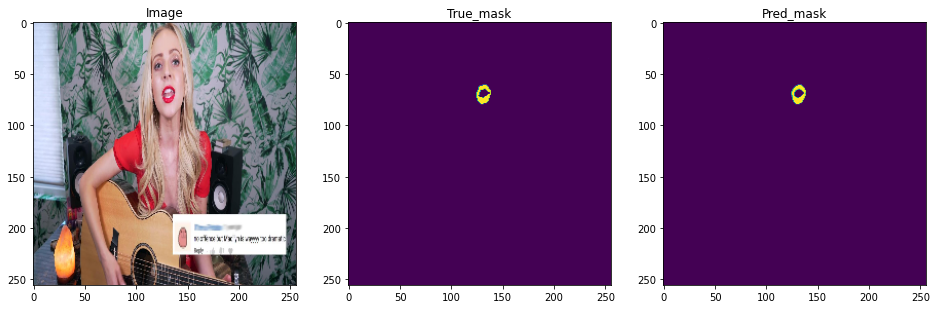

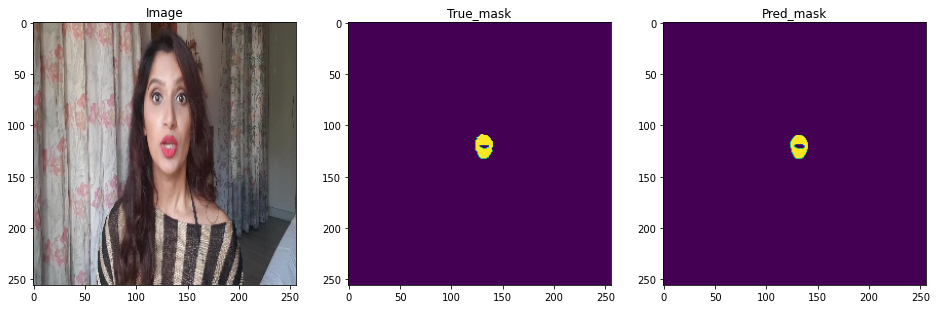

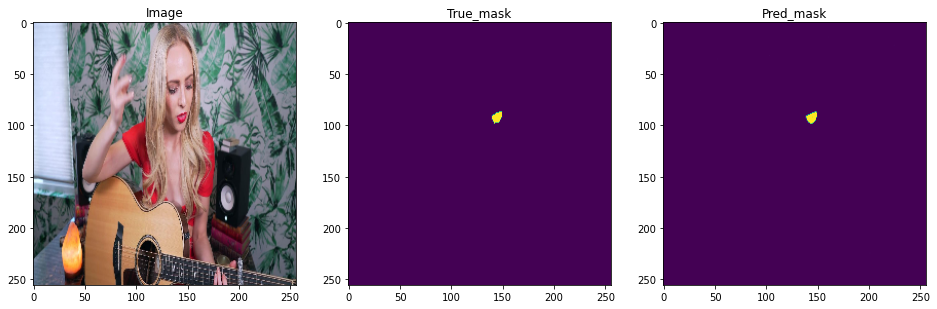

In [ ]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0)[:, :, 0])
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0)[:, :, 0])
    ax_3.set_title('Pred_mask')

**Выводы:**<br>
При анализе исходнымх материалов обнаружил, что для 28594 - 28540 = 54 примеров нету масок, и удалил эти примеры.

Но у нас изначально данные размечены как обычная трёхканальная картинка, где зелёный канал обеспечивает 99% информации, который мы потом только и используем. В зелёнов канале данные выглядят как от 0 до 1, где 1 - губы, 0 - фон, 0..1 - граница.  

Использовалась модель Unet из библиотеки segmentation_models_pytorch с BACKBONE = 'resnet34'.  

Я обучил модель, посмотрел на предсказания, они получились почти индентичными маске. Так же метрика iou_score = 0.8866 на тесте. Что означает, что модель обучалась успешно.